## Development of Models

In [492]:
# for data manipulation
import pandas as pd
import numpy as np

# for making ml pipelines reproducible
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

# for building models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# for data augmentation
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

In [493]:
# helper function for submission
def create_submission(model, test_data):
    predictions = model.predict_proba(test_data)
    test_data["loan_status"] = predictions[:, 1]
    return test_data.reset_index()[["id", "loan_status"]]

### Load Data

In [494]:
# load in training data
train = pd.read_csv("data/train.csv", index_col="id")
validation = train.sample(1000, random_state=42)
train = train.loc[~train.index.isin(validation.index)]
y_train, y_validation = train.pop("loan_status"), validation.pop("loan_status")

# ensuring split worked
print(f"training shape: {train.shape}")
print(f"validation shape: {validation.shape}")

training shape: (57645, 11)
validation shape: (1000, 11)


### First Model = Decision Tree

#### Build Pipeline

In [495]:
numeric_features = [
    "person_age", "person_income", "person_emp_length", "loan_amnt",
    "loan_int_rate", "loan_percent_income", "cb_person_cred_hist_length"
]
categorical_features = [
    "person_home_ownership", "loan_intent",
    "cb_person_default_on_file"
]
ordinal_features = ["loan_grade"]

In [496]:
numeric_transforms = make_pipeline(StandardScaler())
categorical_transforms = make_pipeline(OneHotEncoder(handle_unknown="ignore"))
ordinal_transforms = make_pipeline(
    OrdinalEncoder()
)

# column transformer
preprocessing = ColumnTransformer(transformers=[
    ("numeric", numeric_transforms, numeric_features),
    ("categorical", categorical_transforms, categorical_features),
    ("ordinal", ordinal_transforms, ordinal_features)
])

In [497]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3


In [498]:
tree = make_pipeline(
    preprocessing,
    DecisionTreeClassifier(random_state=42, max_depth=15, max_leaf_nodes=25)
)
tree = tree.fit(train, y_train)

In [499]:
validation_score = tree.score(validation, y_validation)
training_score = tree.score(train, y_train)

# displaying scores of training vs validation
print(f"training accuracy: {training_score}")
print(f"validation accuracy: {validation_score}")

training accuracy: 0.9501951600312256
validation accuracy: 0.957


In [500]:
output = create_submission(tree, pd.read_csv("data/test.csv", index_col="id"))

In [501]:
output.to_csv("output/dt_tuned.csv", index=False)

### Second Model = Random Forest

In [502]:
# building a forest pipeline
forest = make_pipeline(
    preprocessing,
    RandomForestClassifier(random_state=42, max_depth=20)
)
forest = forest.fit(train, y_train)

In [503]:
# fitting and scoring model
training_score = forest.score(train, y_train)
validation_score = forest.score(validation, y_validation)

# view results
print(f"training accuracy: {training_score}")
print(f"validation accuracy: {validation_score}")

training accuracy: 0.9826871367854975
validation accuracy: 0.96


In [504]:
# create submission
forest_submission = create_submission(forest, pd.read_csv("data/test.csv", index_col="id"))
forest_submission.to_csv("output/forest.csv", index=False)

### Third Model = MLP Classifier

In [505]:
# try a neural network
nn = make_pipeline(
    preprocessing,
    MLPClassifier(
        hidden_layer_sizes=(128, 64,), alpha=0.01,
        random_state=42, max_iter=1000, n_iter_no_change=10)
)
# nn = nn.fit(train, y_train)

In [506]:
# scoring
# training_score = nn.score(train, y_train)
# validation_score = nn.score(validation, y_validation)
# 
# # view scoring
# print(f"training accuracy: {training_score}")
# print(f"validation accuracy: {validation_score}")

In [507]:
# make submission
# nn_output = create_submission(nn, pd.read_csv("data/test.csv", index_col="id"))
# nn_output.to_csv("output/nn.csv", index=False)

## Feature Engineering

### Visualization

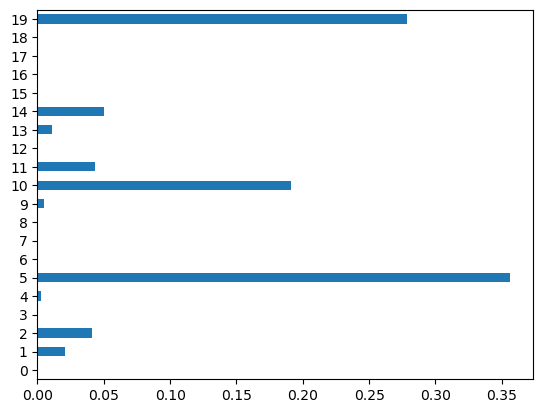

In [508]:
# decision tree feature importance
bar_plot = pd.Series(tree.steps[1][1].feature_importances_).plot(kind="barh")

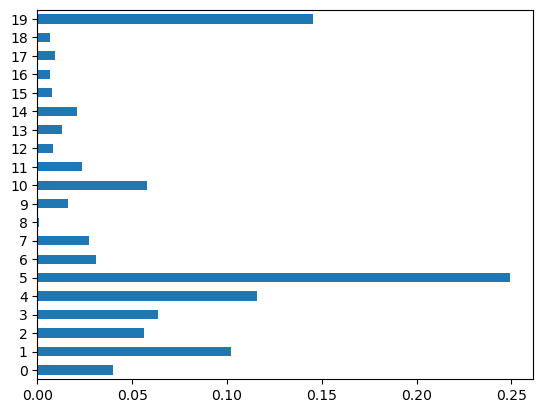

In [509]:
# random forest feature importance
bar_plot2 = pd.Series(forest.steps[1][1].feature_importances_).plot(kind="barh")

### PCA

In [510]:
# using pca analysis
pca = PCA(n_components=15)
pca_pipeline = make_pipeline(preprocessing, pca)
train_pca = pca_pipeline.fit_transform(train)
pca_pipeline[1].explained_variance_ratio_.sum()

0.9932214850692359

In [511]:
# fitting model
forest_pca = make_pipeline(
    pca_pipeline, RandomForestClassifier(random_state=42, max_leaf_nodes=50)
)
forest_pca = forest_pca.fit(train, y_train)

In [512]:
# scoring
train_score = forest_pca.score(train, y_train)
validation_score = forest_pca.score(validation, y_validation)

print(f"training accuracy: {train_score}")
print(f"validation accuracy: {validation_score}")

training accuracy: 0.9287709254922369
validation accuracy: 0.939


### Data Augmentation

In [513]:
def pca_augmentation(data):
    pca_ = PCA(n_components=20)
    data_pca = pca_.fit_transform(data)
    less_data_pca = data_pca - 0.01
    more_data_pca = data_pca + 0.01

    output_ = pca_.inverse_transform(
        np.concatenate([less_data_pca, data_pca, more_data_pca])
    )
    return output_

In [514]:
pca_pipeline = make_pipeline(
    preprocessing,
    FunctionTransformer(pca_augmentation)
)
train_preprocessed = pca_pipeline.fit_transform(train)
y_train_preprocessed = np.tile(y_train, 3).reshape(-1, 1)
tree = DecisionTreeClassifier(random_state=42, max_depth=35, max_leaf_nodes=70) \
    .fit(train_preprocessed, y_train_preprocessed)

model_pipeline = make_pipeline(preprocessing, tree)
model_pipeline.score(validation, y_validation)

0.958

In [518]:
pca_submission = create_submission(model_pipeline, pd.read_csv("data/test.csv", index_col="id"))
pca_submission.to_csv("output/pca_da.csv", index=False)

### Class Imbalance Tuning

In [515]:
# building model
class_imbalance_pipeline = make_pipeline(
    preprocessing,
    RandomForestClassifier(n_estimators=400, random_state=42, max_depth=35, max_leaf_nodes=70)
)
class_imbalance_pipeline = class_imbalance_pipeline.fit(train, y_train)

In [516]:
# scoring model
training_score = class_imbalance_pipeline.score(train, y_train)
validation_score = class_imbalance_pipeline.score(validation, y_validation)

# show scores
print(f"training accuracy: {training_score}")
print(f"validation accuracy: {validation_score}")

training accuracy: 0.949397172347992
validation accuracy: 0.954


In [517]:
# create submission
class_imbalance_submission = create_submission(class_imbalance_pipeline, pd.read_csv("data/test.csv", index_col="id"))
class_imbalance_submission.to_csv("output/class_imbalance.csv", index=False)